In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My Drive/URCOMPU_project1/code
%ls

/content/drive/My Drive/URCOMPU_project1/code
data.py      magnetic_visualize.py  __pycache__/  waypoints_visualize.py
DLmethod.py  maintrain.ipynb        samplecode/   wifi_visualize.py


In [9]:
import numpy as np
import random
import json
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from data import split_floor_data
from sklearn.preprocessing import StandardScaler


random.seed(2)
torch.manual_seed(2)
class FloorData(Dataset):
    def __init__(self, floordata):
        self.features = floordata[:, 2:]
        self.labels = floordata[:, :2]
        self.length = floordata.shape[0]

    def __getitem__(self, index):
        return self.features[index], self.labels[index]

    def __len__(self):
        return self.length

#------------------------------------------  model

class Encoder(nn.Module):
    def __init__(self, wifi_dim, ibeacon_dim, output_dim=32, hidden_magn=32, hidden_wifi=64, hidden_ibeacon=64, drop_rate=0.4, actfunc=nn.ReLU, use_wifi=True, use_ibeacon=True):
        super(Encoder, self).__init__()
        self.activate_function = actfunc
        self.wifi_dim = wifi_dim 
        self.ibeacon_dim = ibeacon_dim
        self.feature_dim = 4+hidden_magn+(hidden_ibeacon+1 if use_ibeacon else 0)+(hidden_wifi+1 if use_wifi else 0)
        self.use_wifi = use_wifi
        self.use_ibeacon = use_ibeacon

        self.magn_encoder = nn.Sequential(
            nn.Linear(4, hidden_magn*2),
            nn.BatchNorm1d(hidden_magn*2),
            nn.Dropout(drop_rate*0.25),
            actfunc(),
            nn.Linear(hidden_magn*2, hidden_magn),
            )

        self.wifi_encoder = nn.Sequential(
            nn.Linear(wifi_dim+1, hidden_wifi*4),
            nn.BatchNorm1d(hidden_wifi*4),
            nn.Dropout(drop_rate*0.5),
            actfunc(),
            nn.Linear(hidden_wifi*4, hidden_wifi*2),
            nn.BatchNorm1d(hidden_wifi*2),
            nn.Dropout(drop_rate),
            actfunc(),
            nn.Linear(hidden_wifi*2, hidden_wifi),
            )
        
        self.ibeacon_encoder = nn.Sequential(
            nn.Linear(ibeacon_dim+1, hidden_ibeacon*4),
            nn.BatchNorm1d(hidden_ibeacon*4),
            nn.Dropout(drop_rate*0.5),
            actfunc(),
            nn.Linear(hidden_ibeacon*4, hidden_ibeacon*2),
            nn.BatchNorm1d(hidden_ibeacon*2),
            nn.Dropout(drop_rate),
            actfunc(),
            nn.Linear(hidden_ibeacon*2, hidden_ibeacon),
            )

        self.encoder = nn.Sequential(
            nn.BatchNorm1d(self.feature_dim),
            actfunc(),
            nn.Linear(self.feature_dim, output_dim*4),
            nn.BatchNorm1d(output_dim*4),
            nn.Dropout(drop_rate*0.5),
            actfunc(),
            nn.Linear(output_dim*4, output_dim*2),
            nn.BatchNorm1d(output_dim*2),
            actfunc(), 
            nn.Linear(output_dim*2, output_dim),
            )

    def forward(self, x):
        magn_o, wifi_det, ibeacon_det, wifi_o, ibeacon_o = x.split([4,1,1,self.wifi_dim, self.ibeacon_dim], dim=1)
        
        magn_out = self.magn_encoder(magn_o)

        if self.use_wifi:
            wifi = torch.cat([wifi_det, wifi_o], dim=1)
            wifi_out = self.wifi_encoder(wifi)
        if self.use_ibeacon:
            ibeacon = torch.cat([ibeacon_det, ibeacon_o], dim=1)
            ibeacon_out = self.ibeacon_encoder(ibeacon)

        if self.use_wifi:
            if self.use_ibeacon:
                output = torch.cat([magn_o, magn_out, wifi_out, ibeacon_out, wifi_det, ibeacon_det], dim=1)
            else:
                output = torch.cat([magn_o, magn_out, wifi_out, wifi_det], dim=1)
        else:
            if self.use_ibeacon:
                output = torch.cat([magn_o, magn_out, ibeacon_out, ibeacon_det], dim=1)
            else:
                output = torch.cat([magn_o, magn_out], dim=1)

        output = self.encoder(output)

        return output


class Decoder(nn.Module):
    def __init__(self, input_dim=32, hidden=64, drop_rate=0.2, actfunc=nn.Tanh):
        super(Decoder, self).__init__()
        self.activate_function = actfunc

        self.decoder = nn.Sequential(
            nn.Linear(input_dim, hidden),
            nn.BatchNorm1d(hidden),
            nn.Dropout(drop_rate),
            actfunc(),
            nn.Linear(hidden, hidden*2),
            nn.BatchNorm1d(hidden*2),
            nn.Dropout(drop_rate),
            actfunc(),
            nn.Linear(hidden*2, 2),
            )

    def forward(self, x):
        return self.decoder(x)


class DLnetwork(nn.Module):
    def __init__(self, wifi_dim, ibeacon_dim, augmentation=True, use_wifi=True, use_ibeacon=True):
        super(DLnetwork, self).__init__()
        if not augmentation: # for ground truth data
            self.encoder = Encoder(wifi_dim, ibeacon_dim, output_dim=32, hidden_magn=32, 
                                   hidden_wifi=32, hidden_ibeacon=32, drop_rate=0, actfunc=nn.ReLU,
                                   use_wifi=use_wifi, use_ibeacon=use_ibeacon)
            self.decoder = Decoder(input_dim=32, hidden=64, drop_rate=0, actfunc=nn.ReLU)
        else: # for augmented data
            self.encoder = Encoder(wifi_dim, ibeacon_dim, output_dim=32, hidden_magn=32, 
                                   hidden_wifi=128, hidden_ibeacon=128, drop_rate=0, actfunc=nn.ReLU,
                                   use_wifi=use_wifi, use_ibeacon=use_ibeacon)
            self.decoder = Decoder(input_dim=32, hidden=64, drop_rate=0, actfunc=nn.ReLU)

    def forward(self, x):
        return self.decoder(self.encoder(x))

#---------------------------------------------------------------------

class DLModel:
    def __init__(self, site, floor, batchsize=64, testratio=0.1, device='cuda', use_augmentation=True, use_wifi=True, use_ibeacon=True):
        self.site, self.floor = site, floor
        self.batchsize = batchsize
        self.testratio = testratio
        self.use_augmentation = use_augmentation
        self.trained_epochs = 0
        self.loss_error = [[],[],[]] # trainloss, trainerror, testerror
        self.trainDataLoader, self.testDataLoader = None, None
        self.y_mean, self.y_std = None, None
        self.lr = None
        self.model = None
        self.bssid2index = None
        self.uuid2index = None 
        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')
        self.use_wifi=use_wifi
        self.use_ibeacon=use_ibeacon
        self.scaler=None

    def initial(self):
        self.load_data()
        self.initial_model(len(self.bssid2index), len(self.uuid2index))

    def load_data(self): # create a dataloader for train and test
        print('Loading and preprocessing data from txt...')
        train_set, test_set, (self.bssid2index, self.uuid2index) = split_floor_data(self.site, self.floor, self.testratio, augmentation=self.use_augmentation)
        scaler = StandardScaler()
        self.scaler=scaler
        train_set[:,2:6] = scaler.fit_transform(train_set[:,2:6].copy())
        test_set[:,2:6] = scaler.transform(test_set[:,2:6].copy())
        y = train_set[:, :2]
        self.y_mean, self.y_std = torch.Tensor(y.mean(axis=0)).to(self.device), torch.Tensor(y.std(axis=0)).to(self.device)
        self.trainDataLoader = DataLoader(FloorData(train_set), batch_size=self.batchsize, shuffle=True)
        self.testDataLoader = DataLoader(FloorData(test_set), batch_size=self.batchsize, shuffle=False)
        print('data loading finish')

    def initial_model(self, wifi_dim, ibeacon_dim):
        self.model = DLnetwork(wifi_dim, ibeacon_dim, augmentation=self.use_augmentation, 
            use_wifi=self.use_wifi, use_ibeacon=self.use_ibeacon).to(self.device)
        print('model initialization finish')

    def train(self, epochs, reduce_lr_epoch=5, startlr=0.1):
        if startlr is None:
            if self.lr is None:
                cur_lr = 0.01
            else:
                cur_lr = self.lr 
        else:
            cur_lr = startlr
            self.lr = cur_lr
        optimizer = torch.optim.Adam(self.model.parameters(), lr=cur_lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, 
                                                               patience=reduce_lr_epoch, cooldown=5, min_lr=1e-5)
        criterion = nn.MSELoss()
        self.model.train()
        for epoch in range(1, epochs+1):
            epoch_loss = 0
            epoch_error = 0
            batch_number = 0

            for x, y in iter(self.trainDataLoader):
                batch_number += 1 
                x = x.float().to(self.device)
                y = y.float().to(self.device)
                pred = self.model(x)
                error = torch.sum(torch.sqrt(torch.sum((y-(pred*self.y_std + self.y_mean))**2, dim=1))) / y.shape[0]
                epoch_error += error.detach().item()

                loss = criterion(pred, (y-self.y_mean)/self.y_std)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                epoch_loss += loss.detach().item()

            mean_loss = epoch_loss / batch_number
            mean_error = epoch_error / batch_number
            test_error = self.evaluate()
            self.trained_epochs += 1
            self.loss_error[0].append(mean_loss)
            self.loss_error[1].append(mean_error)
            self.loss_error[2].append(test_error)
            print(f'epoch: {self.trained_epochs} | lr: {optimizer.param_groups[0]["lr"]} |epoch loss: {mean_loss} | \
                Euclidean distance error on epoch: {mean_error}| Euclidean distance error on TestSet: {test_error} ')   
            scheduler.step(mean_loss)



    def evaluate(self):
        self.model.eval()
        total_error = 0
        batch_number = 0
        with torch.no_grad():
            for x, y in iter(self.testDataLoader):
                batch_number += 1 
                x = x.float().to(self.device)
                y = y.float().to(self.device)
                pred = self.model(x)
                error = torch.sum(torch.sqrt(torch.sum((y-(pred*self.y_std + self.y_mean))**2, dim=1))) / y.shape[0]
                total_error += error
        mean_error = total_error / batch_number
        return mean_error


    def plotloss(self):
        epochs = list(range(1, len(self.loss_error[0])+1))
        if not epochs:
            print(f'0 epoch trained')
            return

        plt.clf()
        fig = plt.figure(figsize=(12,8), dpi=80)
        loss_fig = fig.add_subplot(2,1,1)
        error_fig = fig.add_subplot(2,1,2)
        loss_fig.plot(epochs, self.loss_error[0], label='train loss',linestyle='-', color='red')
        error_fig.plot(epochs, self.loss_error[1], label='train error', linestyle='-', color='blue')
        error_fig.plot(epochs, self.loss_error[2], label='test error', linestyle='-', color='green')
        loss_fig.legend(loc='upper right')
        error_fig.legend(loc='upper right')
        plt.show()


    def predict(self, data, groundtruth=None):
        # data = {Mx, My, Mz, {bssid:rssi}, {uuid:rssi}}
        self.model.eval()
        x = torch.zeros([1,6+len(self.bssid2index)+len(self.uuid2index)])
        Mx, My, Mz = data[:3]
        MI = (Mx**2 + My**2 + Mz**2)**0.5
        Mx, My, Mz, MI = self.scaler.transform(np.array([[Mx,My,Mz,MI]]))[0]
        wifis = data[3]
        ibeacons = data[4]
        wifi_det, ibeacon_det = 1 if wifis else 0, 1 if ibeacons else 0
        x[0][:6] = torch.Tensor([[Mx, My, Mz, MI, wifi_det, ibeacon_det]])
        for bssid, rssi in wifis.items():
            if bssid in self.bssid2index:
                x[0][6+self.bssid2index[bssid]] = (100+rssi) / 100 
        for uuid, rssi in ibeacons.items():
            if uuid in self.uuid2index:
                x[0][6+len(self.bssid2index)+self.uuid2index[uuid]] = (100+rssi) / 100
        x = x.to(self.device)

        pred = self.model(x)
        pred = pred * self.y_std + self.y_mean
        pred = (float(pred[0][0]), float(pred[0][1]))

        plt.clf()
        plt.figure(figsize=(6,6), dpi=160)
        json_path = os.path.join('../data', self.site, self.floor, 'floor_info.json')
        with open(json_path) as file:
            mapinfo = json.load(file)['map_info']
        mapheight, mapwidth = mapinfo['height'], mapinfo['width']
        img = mpimg.imread(os.path.join('../data', self.site, self.floor, 'floor_image.png'))
        plt.imshow(img)
        mapscaler = (img.shape[0]/mapheight + img.shape[1]/mapwidth)/2
        pre = plt.scatter([pred[0]*mapscaler], [img.shape[0] - pred[1]*mapscaler], color='red', marker='o', s=7)
        if groundtruth:
            real = plt.scatter([groundtruth[0]*mapscaler], [img.shape[0] - groundtruth[1]*mapscaler], color='green', marker='x', s=7)
            plt.legend([pre, real], ['prediction', 'groundtruth'], loc='lower left')
        else:
            plt.legend([pre], ['prediction'], loc='lower left')
        plt.xticks((np.arange(25, mapwidth, 25) * mapscaler).astype('uint'), np.arange(25, mapwidth, 25).astype('uint'))
        plt.yticks((img.shape[0] - np.arange(25, mapheight, 25) * mapscaler).astype('uint'), np.arange(25, mapheight, 25).astype('uint'))
        plt.show()




'''
use_augmentation: Whether use augmented data or GroundTruth data 
use_wifi:     Whether use wifi feature
use_ibeacon:    Whether use ibeacon feature
'''
model = DLModel('site2', 'F4', batchsize=64, device='cuda', testratio=0.2, use_augmentation=False, use_wifi=True, use_ibeacon=True)
model.initial()



Loading and preprocessing data from txt...
already read 10 txts
already read 20 txts
Total data instance: 215, train number: 172, test number: 43

There are 19 steps that did not find wifi, and 151 steps that did not find ibeacon.
There are 2 bssids and 0 uuids which were detected in testset while not detected in trainset, so that they were discard.
Final wifi bssid number: 1959, ibeacon uuid number: 11
data loading finish
model initialization finish


In [10]:
model.train(300, reduce_lr_epoch=15, startlr=0.01)

epoch: 1 | lr: 0.01 |epoch loss: 1.145545482635498 |                 Euclidean distance error on epoch: 65.88672256469727| Euclidean distance error on TestSet: 60.70580291748047 
epoch: 2 | lr: 0.01 |epoch loss: 0.9716813961664835 |                 Euclidean distance error on epoch: 62.002813975016274| Euclidean distance error on TestSet: 53.225955963134766 
epoch: 3 | lr: 0.01 |epoch loss: 0.7083873550097147 |                 Euclidean distance error on epoch: 51.15181223551432| Euclidean distance error on TestSet: 40.04210662841797 
epoch: 4 | lr: 0.01 |epoch loss: 0.48524343967437744 |                 Euclidean distance error on epoch: 38.97586313883463| Euclidean distance error on TestSet: 33.14230728149414 
epoch: 5 | lr: 0.01 |epoch loss: 0.4142582416534424 |                 Euclidean distance error on epoch: 34.7713820139567| Euclidean distance error on TestSet: 30.325620651245117 
epoch: 6 | lr: 0.01 |epoch loss: 0.3175956706206004 |                 Euclidean distance error on 

<Figure size 432x288 with 0 Axes>

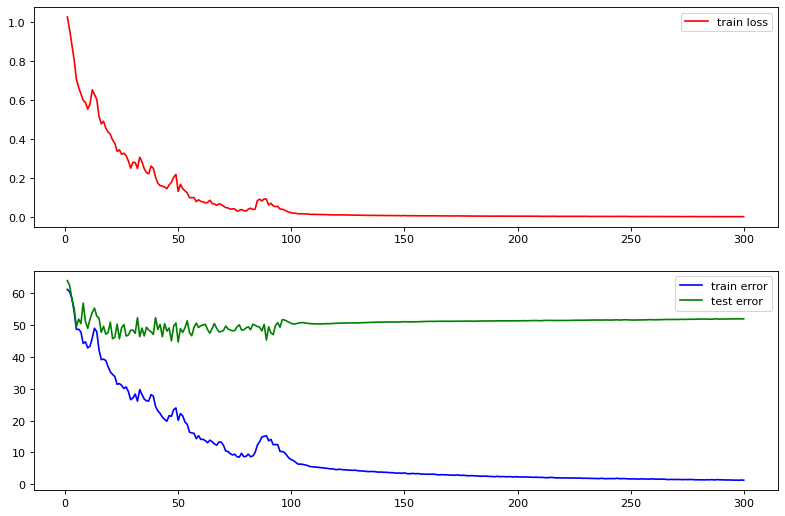

0.01

In [ ]:
model.plotloss()
model.lr
# for i in temp_test_error:
#     print(i)
# print()
# print('average of error which larger than 25:  ', sum(map(lambda t: ((t[0][0]-t[1][0])**2+(t[0][1]-t[1][1])**2)**0.5, temp_test_error))/len(temp_test_error))
# print('average of error which less than 25:  ', (29.241338*182 - sum(map(lambda t: ((t[0][0]-t[1][0])**2+(t[0][1]-t[1][1])**2)**0.5, temp_test_error))) / (182-len(temp_test_error)))

<Figure size 432x288 with 0 Axes>

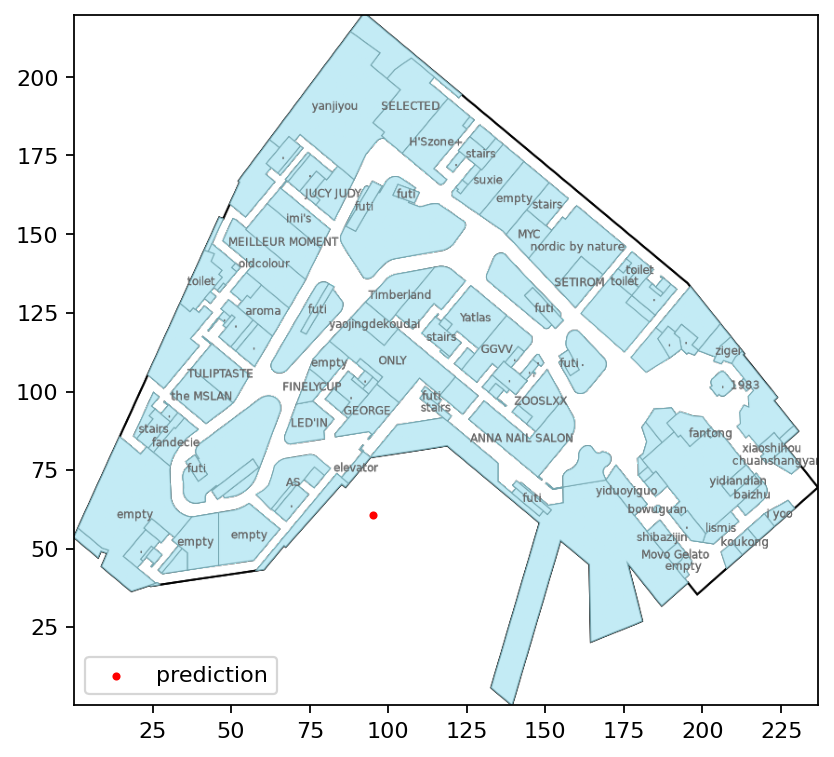

In [ ]:
model.predict([9.695435, 35.49347, -36.782837, {
        "04:40:a9:a1:9a:61": -50,
        "04:40:a9:a1:87:61": -56,
        "04:40:a9:a1:95:01": -65,
        "04:40:a9:a1:7d:e1": -72,
    }, {}])